In [4]:
import os
os.environ['PYSR_AUTOLOAD_EXTENSIONS'] = 'no'
from matplotlib import pyplot as plt
from interpret import paretoize, overall_complexity
from utils import load_pickle
%matplotlib inline

In [5]:
# version = 11003
# new one
version = 93102
results_path = f'sr_results/{version}.pkl'
reg = load_pickle(results_path)
# results = reg.equations_[0]
results = reg.equations_

In [6]:
d = {2: {'version': 24880,
         'pysr_version': 93102},
     3: {'version': 74649,
         'pysr_version': 49636},
     4: {'version': 11566,
         'pysr_version': 94842},
     5: {'version': 72646,
         'pysr_version': 42503}}

In [7]:
k_results = {}
for k, v in d.items():
    # load the original PySR table
    pysr_version = v['pysr_version']
    version = v['version']
    pysr_results = load_pickle(f'sr_results/{pysr_version}.pkl').equations_
    try:
        all_rmses = load_pickle(f'pickles/pysr_results_all_{version}_{pysr_version}.pkl')['test']
    except FileNotFoundError:
        print(f'File not found for {version} and {pysr_version}')

    results = {}
    for comp in all_rmses.keys():
        eq = pysr_results[pysr_results['complexity'] == comp].iloc[0]
        overall_comp = overall_complexity(eq, k)
        results[overall_comp] = all_rmses[comp]

    k_results[k] = results

In [8]:
f2_linear_models = {
    20: 8880,
    10: 22697,
    5: 13523,
    2: 22649,
    0: 4014,
}

In [9]:
def nn_test_rmse(version):
    return load_pickle(f'pickles/nn_results_all_{version}.pkl')['test']

In [10]:
# calculate overall complexity
def overall_complexity_f2_linear(k):
    '''
    - k features. each feature is mean/std of a k'=2 input feature, which has complexity 3.
    - we do a linear combination of the k features, so that is complexity 5k (3 for each feature, 2 for the product and sum for the linear combination)
    - also there's a bias term, so that adds 1 more complexity
    - total complexity: 5k + 1
    '''
    return 5 * k + 1

f2_linear_results = {
    overall_complexity_f2_linear(k): nn_test_rmse(v) for k, v in f2_linear_models.items()
}

In [11]:
f2_linear_results

{101: 1.3330038776269764,
 51: 1.3281052980644596,
 26: 1.3598535068236015,
 11: 1.406128772172693,
 1: 1.516650138317775}

In [12]:
f1_id_results = load_pickle('pickles/pysr_results_all_28114_9054.pkl')['test']

In [13]:
pure_sr_results = load_pickle('pickles/pure_sr_results_all_83941.pkl')['test']
# get rid of entries with rmse over 2.0, because they were probably invalid equations
pure_sr_results = {k: v for k, v in pure_sr_results.items() if v < 2.0}

In [14]:
def plot_k():
    plt.rcParams["font.family"] = "serif"
    plt.figure(figsize=(8, 5))
    ax = plt.gca()

    # plot k results
    for k in k_results:
        result = k_results[k]
        x, y = zip(*result.items())
        x, y = paretoize(x, y, replace=False)
        label = f'$k = {k}$' if k != 2 else '$k = 2$ (Ours)'
        ax.plot(x, y, marker='^', label=label)

    ax.set_xlabel('Overall complexity', fontsize=14, labelpad=10)
    ax.set_ylabel('RMSE (Resonant)', fontsize=14, labelpad=10)
    ax.legend()
    plt.tight_layout()
    plt.savefig('graphics/top_k_pareto.png', dpi=400, bbox_inches='tight')
    plt.show()


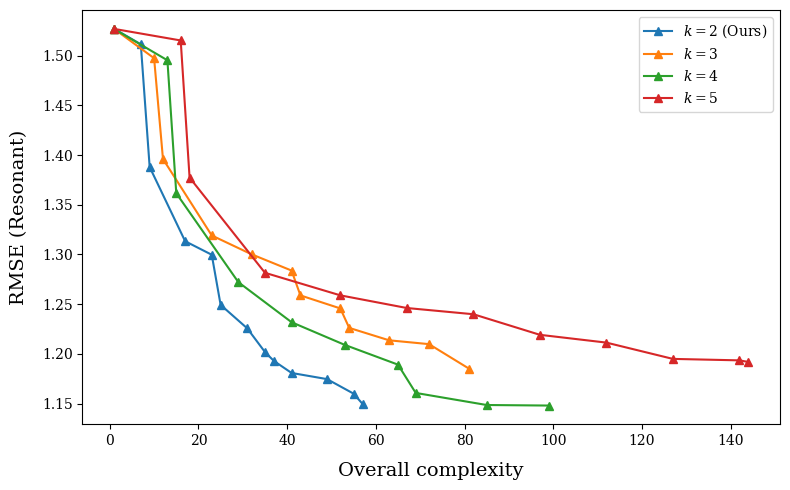

In [15]:
plot_k()

In [24]:
def plot_all():
    plt.rcParams["font.family"] = "serif"
    plt.figure(figsize=(8, 5))
    ax = plt.gca()

    # plot k=2 results
    k = 2
    result = k_results[k]
    x, y = zip(*result.items())
    x, y = paretoize(x, y, replace=False)
    ax.plot(x, y, marker='^', label='Ours')

    # add f2 linear results
    x, y = zip(*f2_linear_results.items())
    x, y = paretoize(x, y, replace=False)
    ax.plot(x, y, marker='o', label='Linear $\psi$')

    # add f1 id results
    x, y = zip(*f1_id_results.items())
    x, y = paretoize(x, y, replace=False)
    ax.plot(x, y, marker='o', label='Pure SR')

    # add pure SR results
    x, y = zip(*pure_sr_results.items())
    x, y = paretoize(x, y, replace=False)
    ax.plot(x, y, marker='o', label='Pure SR w/ learned features')

    ax.set_xlabel('Overall complexity', fontsize=14, labelpad=10)
    ax.set_ylabel('RMSE (Resonant)', fontsize=14, labelpad=10)
    ax.legend()
    plt.tight_layout()
    plt.savefig('graphics/comparison_pareto.png', dpi=400, bbox_inches='tight')
    plt.show()

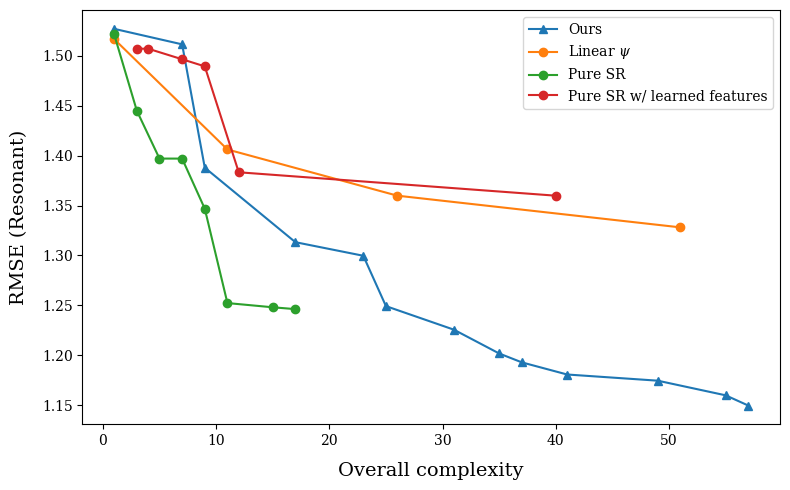

In [25]:
plot_all()